# PhysioNet Motor Imagery - Gating Methods + Channel Selection

This notebook compares channel selection performance across different **EEG-ARNN** variants:

## Models (EEG-ARNN with different gating strategies):
1. **Baseline** - Pure EEG-ARNN (no gating)
2. **Static Gating** - Learnable fixed channel gates
3. **Adaptive Gating** - Input-dependent channel gates
4. **Early Halting** - Progressive channel dropout

## Channel Selection Methods:
- **ES (Edge Selection)** - Select channels by edge importance in adjacency matrix
- **AS (Aggregation Selection)** - Select channels by aggregated connectivity

## Experiment:
- Train each model on full 64 channels
- Use adjacency matrix for channel selection (ES/AS)
- Retrain with k=[10, 15, 20, 25, 30] selected channels
- Compare accuracy drop across methods

**Goal**: Find which EEG-ARNN variant + selection method maintains highest accuracy with fewest channels

## 1. Setup and Imports

In [1]:
import json
import random
import warnings
from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import mne

warnings.filterwarnings('ignore')
sns.set_context('notebook', font_scale=1.0)
mne.set_log_level('WARNING')

def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## 2. Configuration

In [2]:
# Auto-detect Kaggle environmentimport osif os.path.exists('/kaggle/input'):    print("Running on Kaggle")    kaggle_input = Path('/kaggle/input')    datasets = [d for d in kaggle_input.iterdir() if d.is_dir()]    print(f"Available datasets: {[d.name for d in datasets]}")        DATA_DIR = None    possible_names = ['physioneteegmi', 'eeg-motor-movementimagery-dataset']    for ds_name in possible_names:        test_path = kaggle_input / ds_name        if test_path.exists():            DATA_DIR = test_path            print(f"Found dataset: {DATA_DIR}")            break        if DATA_DIR is None and datasets:        DATA_DIR = datasets[0]        print(f"Using first available dataset: {DATA_DIR}")else:    print("Running locally")    DATA_DIR = Path('data/physionet/files')CONFIG = {    'data': {        'raw_data_dir': DATA_DIR,        'selected_classes': [1, 2],  # T1 (left fist), T2 (right fist)        'tmin': -1.0,        'tmax': 5.0,        'baseline': (-0.5, 0)    },    'preprocessing': {        'l_freq': 0.5,        'h_freq': 40.0,        'notch_freq': 50.0,        'target_sfreq': 128.0,        'apply_car': True    },    'model': {        'hidden_dim': 40,        'epochs': 30,        'learning_rate': 1e-3,        'batch_size': 32,        'n_folds': 3,        'patience': 8    },    'gating': {        'l1_lambda': 1e-3,        'gate_init': 0.9,        'halting_threshold': 0.5,        'halting_penalty': 1e-2    },    'carmv2': {        'topk_k': 8,        'lambda_feat': 0.3,        'hop_alpha': 0.5,        'edge_dropout': 0.1,        'use_pairnorm': True,        'use_residual': True,        'low_rank_r': 0    },    'channel_selection': {        'k_values': [10, 15, 20, 25, 30]    },    'output': {        'results_dir': Path('results'),    },    'max_subjects': 20,    'min_runs_per_subject': 8}CONFIG['output']['results_dir'].mkdir(exist_ok=True, parents=True)print(f"\nConfiguration loaded!")print(f"Training: {CONFIG['max_subjects']} subjects, {CONFIG['model']['n_folds']}-fold CV, {CONFIG['model']['epochs']} epochs")

Running on Kaggle
Available datasets: ['physioneteegmi']
Found dataset: /kaggle/input/physioneteegmi

Configuration loaded!
Training: 20 subjects, 3-fold CV, 30 epochs


## 3. Data Cleaning - Remove Faulty Subjects

Based on the quality analysis, we'll exclude subjects with:
- Less than 10 good runs
- Good run ratio < 70%
- Known problematic subjects from EDA

In [3]:
# Known faulty subjects from data cleaning analysis
KNOWN_BAD_SUBJECTS = [
    'S088', 'S089', 'S092', 'S100', 'S104', 'S106', 'S107', 'S108', 'S109'
]

# Additional subjects with high clipping or amplitude issues
HIGH_ISSUE_SUBJECTS = [
    'S003', 'S004', 'S009', 'S010', 'S012', 'S013', 'S017', 'S018', 'S019',
    'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029'
]

EXCLUDED_SUBJECTS = set(KNOWN_BAD_SUBJECTS + HIGH_ISSUE_SUBJECTS)

print(f"Total excluded subjects: {len(EXCLUDED_SUBJECTS)}")
print(f"Excluded subjects: {sorted(EXCLUDED_SUBJECTS)}")

Total excluded subjects: 27
Excluded subjects: ['S003', 'S004', 'S009', 'S010', 'S012', 'S013', 'S017', 'S018', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S088', 'S089', 'S092', 'S100', 'S104', 'S106', 'S107', 'S108', 'S109']


## 4. Data Loading and Preprocessing Functions

In [4]:
def preprocess_raw(raw, config):    """Apply preprocessing to raw EEG data."""    cleaned_names = {name: name.rstrip('.') for name in raw.ch_names}    raw.rename_channels(cleaned_names)    raw.pick_types(eeg=True)    raw.set_montage('standard_1020', on_missing='ignore', match_case=False)        nyquist = raw.info['sfreq'] / 2.0    if config['preprocessing']['notch_freq'] < nyquist:        raw.notch_filter(freqs=config['preprocessing']['notch_freq'], verbose=False)        raw.filter(        l_freq=config['preprocessing']['l_freq'],        h_freq=config['preprocessing']['h_freq'],        method='fir',        fir_design='firwin',        verbose=False    )        if config['preprocessing']['apply_car']:        raw.set_eeg_reference('average', projection=False, verbose=False)        raw.resample(config['preprocessing']['target_sfreq'], npad='auto', verbose=False)    return rawdef load_and_preprocess_edf(edf_path, config):    """Load raw EDF file, preprocess it, and extract epochs."""    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')    raw = preprocess_raw(raw, config)        # Use events_from_annotations to get correct event IDs from annotations    events, event_ids = mne.events_from_annotations(raw, verbose='ERROR')        if len(events) == 0:        return None, None, raw.ch_names        epochs = mne.Epochs(        raw,        events,        event_id=event_ids,        tmin=config['data']['tmin'],        tmax=config['data']['tmax'],        baseline=tuple(config['data']['baseline']),        preload=True,        verbose='ERROR'    )        return epochs.get_data(), epochs.events[:, 2], raw.ch_namesdef filter_classes(x, y, selected_classes):    """Filter to keep only selected classes and remap labels."""    mask = np.isin(y, selected_classes)    y, x = y[mask], x[mask]    label_map = {old: new for new, old in enumerate(sorted(selected_classes))}    y = np.array([label_map[int(label)] for label in y], dtype=np.int64)    return x, ydef normalize(x):    """Z-score normalization per channel."""    mu = x.mean(axis=(0, 2), keepdims=True)    sd = x.std(axis=(0, 2), keepdims=True) + 1e-8    return (x - mu) / sddef load_subject_data(data_dir, subject_id, run_ids, config):    """Load all runs for a subject, preprocess, and concatenate."""    subject_dir = data_dir / subject_id    if not subject_dir.exists():        return None, None, None        all_x, all_y = [], []    channel_names = None        for run_id in run_ids:        edf_path = subject_dir / f'{subject_id}{run_id}.edf'        if not edf_path.exists():            continue                try:            x, y, ch_names = load_and_preprocess_edf(edf_path, config)            if x is None or len(y) == 0:                continue                        x, y = filter_classes(x, y, config['data']['selected_classes'])            if len(y) == 0:                continue                        channel_names = channel_names or ch_names            all_x.append(x)            all_y.append(y)        except Exception as e:            print(f"  Warning: Failed to load {edf_path.name}: {e}")            continue        if len(all_x) == 0:        return None, None, channel_names        return np.concatenate(all_x, 0), np.concatenate(all_y, 0), channel_namesdef get_available_subjects(data_dir, min_runs=8, excluded=None):    """Get list of subjects with at least min_runs available, excluding bad subjects."""    if not data_dir.exists():        raise ValueError(f"Data directory not found: {data_dir}")        excluded = excluded or set()    subjects = []        for subject_dir in sorted(data_dir.iterdir()):        if not subject_dir.is_dir() or not subject_dir.name.startswith('S'):            continue                # Skip excluded subjects        if subject_dir.name in excluded:            continue                edf_files = list(subject_dir.glob('*.edf'))        if len(edf_files) >= min_runs:            subjects.append(subject_dir.name)        return subjects# Scan for available subjectsprint("\nScanning for subjects...")data_dir = CONFIG['data']['raw_data_dir']print(f"Looking for data in: {data_dir}")all_subjects = get_available_subjects(    data_dir,     min_runs=CONFIG['min_runs_per_subject'],    excluded=EXCLUDED_SUBJECTS)subjects = all_subjects[:CONFIG['max_subjects']]print(f"Found {len(all_subjects)} clean subjects with >= {CONFIG['min_runs_per_subject']} runs")print(f"Will process {len(subjects)} subjects: {subjects}")# Define which runs to useMOTOR_IMAGERY_RUNS = ['R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']MOTOR_EXECUTION_RUNS = ['R03', 'R04', 'R05', 'R06']ALL_TASK_RUNS = MOTOR_IMAGERY_RUNS + MOTOR_EXECUTION_RUNSprint(f"Using runs: {ALL_TASK_RUNS}")


Scanning for subjects...
Looking for data in: /kaggle/input/physioneteegmi
Found 82 clean subjects with >= 8 runs
Will process 20 subjects: ['S001', 'S002', 'S005', 'S006', 'S007', 'S008', 'S011', 'S014', 'S015', 'S016', 'S020', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038']
Using runs: ['R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14', 'R03', 'R04', 'R05', 'R06']


## 5. PyTorch Dataset

In [5]:
class EEGDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x).unsqueeze(1)  # Add channel dim for Conv2d
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

## 6. Model Architectures

### 6.1 Baseline EEG-ARNN (Pure CNN-GCN)

In [6]:
class GraphConvLayer(nn.Module):
    """Graph Convolution Layer with learned adjacency."""
    def __init__(self, num_channels, hidden_dim):
        super().__init__()
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim
        
        # Learnable adjacency matrix
        self.A = nn.Parameter(torch.randn(num_channels, num_channels))
        self.theta = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.bn = nn.BatchNorm2d(hidden_dim)
        self.act = nn.ELU()
    
    def forward(self, x):
        B, H, C, T = x.shape
        
        # Normalize adjacency matrix
        A = torch.sigmoid(self.A)
        A = 0.5 * (A + A.t())
        I = torch.eye(C, device=A.device)
        A_hat = A + I
        D = torch.diag(torch.pow(A_hat.sum(1).clamp_min(1e-6), -0.5))
        A_norm = D @ A_hat @ D
        
        # Graph convolution
        x_batch = x.permute(0, 3, 2, 1).contiguous().view(B*T, C, H)
        x_g = A_norm @ x_batch
        x_g = self.theta(x_g)
        x_g = x_g.view(B, T, C, H).permute(0, 3, 2, 1)
        
        x_out = self.bn(x_g)
        x_out = self.act(x_out)
        
        return x_out
    
    def get_adjacency(self):
        with torch.no_grad():
            A = torch.sigmoid(self.A)
            A = 0.5 * (A + A.t())
            return A.cpu().numpy()


class TemporalConv(nn.Module):
    """Temporal Convolution Layer."""
    def __init__(self, in_channels, out_channels, kernel_size=16, pool=True):
        super().__init__()
        self.pool = pool
        self.conv = nn.Conv2d(in_channels, out_channels, 
                            kernel_size=(1, kernel_size), 
                            padding=(0, kernel_size//2), bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ELU()
        self.pool_layer = nn.AvgPool2d(kernel_size=(1, 2)) if pool else None
    
    def forward(self, x):
        x = self.act(self.bn(self.conv(x)))
        return self.pool_layer(x) if self.pool else x


class BaselineEEGARNN(nn.Module):
    """Baseline EEG-ARNN with pure CNN-GCN architecture."""
    def __init__(self, C, T, K, H):
        super().__init__()
        self.t1 = TemporalConv(1, H, 16, False)
        self.g1 = GraphConvLayer(C, H)
        self.t2 = TemporalConv(H, H, 16, True)
        self.g2 = GraphConvLayer(C, H)
        self.t3 = TemporalConv(H, H, 16, True)
        self.g3 = GraphConvLayer(C, H)
        
        with torch.no_grad():
            ft = self._forward_features(torch.zeros(1, 1, C, T))
            fs = ft.view(1, -1).size(1)
        
        self.fc1 = nn.Linear(fs, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, K)
    
    def _forward_features(self, x):
        x = self.g1(self.t1(x))
        x = self.g2(self.t2(x))
        x = self.g3(self.t3(x))
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)
    
    def get_final_adjacency(self):
        return self.g3.get_adjacency()


print("Baseline EEG-ARNN architecture defined!")

Baseline EEG-ARNN architecture defined!


### 6.2 Gated CARM

In [ ]:
class StaticGatedEEGARNN(BaselineEEGARNN):
    """EEG-ARNN with static learnable channel gates."""
    def __init__(self, C, T, K, H, gate_init=0.9):
        super().__init__(C, T, K, H)
        init = torch.full((C,), float(gate_init), dtype=torch.float32)
        init = torch.clamp(init, 1e-4, 1 - 1e-4)
        gate_logits = torch.logit(init)
        self.gate_logits = nn.Parameter(gate_logits)
        self.latest_gates = None
    
    def get_gate_values(self):
        return torch.sigmoid(self.gate_logits)
    
    def forward(self, x):
        gate_values = torch.sigmoid(self.gate_logits)
        self.latest_gates = gate_values.detach().cpu()
        x = x * gate_values.view(1, 1, -1, 1)
        return super().forward(x)


# Keep GatedEEGARNN as alias for backward compatibility
GatedEEGARNN = StaticGatedEEGARNN

print("Static Gating architecture defined!")

### 6.3 Adaptive Gating

In [ ]:
class AdaptiveGatedEEGARNN(BaselineEEGARNN):
    """EEG-ARNN with adaptive input-dependent channel gates."""
    def __init__(self, C, T, K, H, gate_init=0.9):
        super().__init__(C, T, K, H)
        
        # Gate network
        self.gate_net = nn.Sequential(
            nn.Linear(C * 2, C),
            nn.ReLU(),
            nn.Linear(C, C),
            nn.Sigmoid()
        )
        
        with torch.no_grad():
            self.gate_net[-2].bias.fill_(2.0)
        
        self.latest_gates = None
    
    def compute_gates(self, x):
        B, _, C, T = x.shape
        x_squeeze = x.squeeze(1)
        ch_mean = x_squeeze.mean(dim=2)
        ch_std = x_squeeze.std(dim=2)
        stats = torch.cat([ch_mean, ch_std], dim=1)
        gates = self.gate_net(stats)
        return gates
    
    def forward(self, x):
        gates = self.compute_gates(x)
        self.latest_gates = gates.detach().cpu()
        x = x * gates.view(-1, 1, gates.size(1), 1)
        return super().forward(x)
    
    def get_gate_values(self):
        if self.latest_gates is not None:
            return self.latest_gates.mean(dim=0)
        return None


print("Adaptive Gating architecture defined!")

### 6.4 Early Halting

In [ ]:
class EarlyHaltingEEGARNN(BaselineEEGARNN):
    """EEG-ARNN with progressive channel halting."""
    def __init__(self, C, T, K, H, halt_threshold=0.5):
        super().__init__(C, T, K, H)
        
        self.halt_net = nn.Sequential(
            nn.Linear(C * 2, C),
            nn.ReLU(),
            nn.Linear(C, C),
            nn.Sigmoid()
        )
        
        self.halt_threshold = halt_threshold
        self.latest_halt_probs = None
        self.latest_active_mask = None
    
    def compute_halting_probs(self, x):
        B, _, C, T = x.shape
        x_squeeze = x.squeeze(1)
        ch_mean = x_squeeze.mean(dim=2)
        ch_std = x_squeeze.std(dim=2)
        stats = torch.cat([ch_mean, ch_std], dim=1)
        halt_probs = self.halt_net(stats)
        return halt_probs
    
    def forward(self, x):
        halt_probs = self.compute_halting_probs(x)
        self.latest_halt_probs = halt_probs.detach().cpu()
        
        if self.training:
            active_mask = 1.0 - halt_probs
        else:
            active_mask = (halt_probs < self.halt_threshold).float()
        
        self.latest_active_mask = active_mask.detach().cpu()
        x = x * active_mask.view(-1, 1, active_mask.size(1), 1)
        return super().forward(x)
    
    def get_gate_values(self):
        if self.latest_active_mask is not None:
            return self.latest_active_mask.mean(dim=0)
        return None


print("Early Halting architecture defined!")

### 6.3 CARMv2

In [8]:
def pairnorm(x, node_dim=2, eps=1e-6):
    m = x.mean(dim=node_dim, keepdim=True)
    xc = x - m
    v = (xc * xc).mean(dim=node_dim, keepdim=True)
    return xc / torch.sqrt(v + eps)


def build_feat_topk_adj(x, k):
    B, H, C, T = x.shape
    E = x.permute(2, 1, 0, 3).contiguous().view(C, H, B*T).mean(2)
    En = F.normalize(E, p=2, dim=1)
    S = (En @ En.t()).clamp_min(0.0)
    k = max(1, min(int(k), C))
    vals, idx = torch.topk(S, k, dim=1)
    M = torch.zeros_like(S)
    M.scatter_(1, idx, 1.0)
    A = S * M
    A = torch.softmax(A, 1)
    A = 0.5 * (A + A.t())
    return A


class CARMv2Layer(nn.Module):
    def __init__(self, C, H, cfg):
        super().__init__()
        self.C = C
        self.H = H
        self.k = int(cfg['topk_k'])
        self.lf = float(cfg['lambda_feat'])
        self.ha = float(cfg['hop_alpha'])
        self.ed = float(cfg['edge_dropout'])
        self.pn = bool(cfg['use_pairnorm'])
        self.res = bool(cfg['use_residual'])
        r = int(cfg['low_rank_r'])
        
        if r > 0:
            self.B = nn.Parameter(torch.empty(C, r))
            nn.init.xavier_uniform_(self.B)
            self.W = None
        else:
            self.W = nn.Parameter(torch.empty(C, C))
            nn.init.xavier_uniform_(self.W)
            self.B = None
        
        self.th = nn.Linear(H, H, bias=False)
        self.bn = nn.BatchNorm2d(H)
        self.act = nn.ELU()
        self.last = None
    
    def _learned(self, dev):
        W = self.W if self.B is None else (self.B @ self.B.t())
        A = torch.sigmoid(W)
        A = 0.5 * (A + A.t())
        I = torch.eye(self.C, device=dev, dtype=A.dtype)
        At = A + I
        d = torch.pow(At.sum(1).clamp_min(1e-6), -0.5)
        D = torch.diag(d)
        return D @ At @ D
    
    def forward(self, x):
        B, H, C, T = x.shape
        Al = self._learned(x.device)
        A2 = Al @ Al
        Ah = (1 - self.ha) * Al + self.ha * A2
        Af = build_feat_topk_adj(x, self.k)
        A = (1 - self.lf) * Ah + self.lf * Af
        
        if self.training and self.ed > 0:
            M = (torch.rand_like(A) > self.ed).float()
            A = 0.5 * ((A * M) + (A * M).t())
            A = A + torch.eye(C, device=A.device, dtype=A.dtype)
        
        d = torch.pow(A.sum(1).clamp_min(1e-6), -0.5)
        D = torch.diag(d)
        A = D @ A @ D
        
        xb = x.permute(0, 3, 2, 1).contiguous().view(B*T, C, H)
        xg = A @ xb
        xg = self.th(xg)
        xg = xg.view(B, T, C, H).permute(0, 3, 2, 1)
        
        out = xg + x if self.res else xg
        out = pairnorm(out, 2) if self.pn else out
        out = self.bn(out)
        out = self.act(out)
        
        self.last = {
            'learned': Al.detach().cpu().numpy(),
            'effective': A.detach().cpu().numpy()
        }
        return out
    
    def get_adjs(self):
        return self.last or {}


class CARMv2Model(nn.Module):
    def __init__(self, C, T, K, H, cfg):
        super().__init__()
        self.t1 = TemporalConv(1, H, 16, False)
        self.g1 = CARMv2Layer(C, H, cfg)
        self.t2 = TemporalConv(H, H, 16, True)
        self.g2 = CARMv2Layer(C, H, cfg)
        self.t3 = TemporalConv(H, H, 16, True)
        self.g3 = CARMv2Layer(C, H, cfg)
        
        with torch.no_grad():
            ft = self._f(torch.zeros(1, 1, C, T))
            fs = ft.view(1, -1).size(1)
        
        self.fc1 = nn.Linear(fs, 256)
        self.do = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, K)
    
    def _f(self, x):
        x = self.g1(self.t1(x))
        x = self.g2(self.t2(x))
        x = self.g3(self.t3(x))
        return x
    
    def forward(self, x):
        x = self._f(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.do(x)
        return self.fc2(x)
    
    def get_final_adjacency(self):
        adjs = self.g3.get_adjs()
        return adjs.get('learned', None)


print("CARMv2 architecture defined!")

CARMv2 architecture defined!


## 7. Training Functions

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device, l1_lambda=0.0, halt_penalty=0.0):    model.train()    total_loss = 0.0    all_preds, all_labels = [], []        for x, y in dataloader:        x, y = x.to(device), y.to(device)        optimizer.zero_grad()        logits = model(x)        loss = criterion(logits, y)                # Add L1 regularization for gated models        if l1_lambda > 0 and hasattr(model, 'get_gate_values'):            gate_values = model.get_gate_values()            loss = loss + l1_lambda * gate_values.abs().mean()                # Add halting penalty        if halt_penalty > 0 and hasattr(model, 'latest_active_mask'):            if model.latest_active_mask is not None:                active_count = model.latest_active_mask.mean()                loss = loss + halt_penalty * active_count        loss.backward()        optimizer.step()                total_loss += loss.item()        all_preds += torch.argmax(logits, 1).cpu().tolist()        all_labels += y.cpu().tolist()        return total_loss / max(1, len(dataloader)), accuracy_score(all_labels, all_preds)@torch.no_grad()def evaluate(model, dataloader, criterion, device):    model.eval()    total_loss = 0.0    all_preds, all_labels = [], []        for x, y in dataloader:        x, y = x.to(device), y.to(device)        logits = model(x)        loss = criterion(logits, y)                total_loss += loss.item()        all_preds += torch.argmax(logits, 1).cpu().tolist()        all_labels += y.cpu().tolist()        return total_loss / max(1, len(dataloader)), accuracy_score(all_labels, all_preds)def train_model(model, train_loader, val_loader, device, epochs, lr, patience, l1_lambda=0.0, halt_penalty=0.0):    criterion = nn.CrossEntropyLoss()    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)    scheduler = optim.lr_scheduler.ReduceLROnPlateau(        optimizer, mode='min', factor=0.5, patience=3, verbose=False    )        best_acc = 0.0    best_state = None    no_improve = 0        for epoch in range(epochs):        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, l1_lambda, halt_penalty)        val_loss, val_acc = evaluate(model, val_loader, criterion, device)                scheduler.step(val_loss)                if val_acc > best_acc:            best_acc = val_acc            best_state = deepcopy(model.state_dict())            no_improve = 0        else:            no_improve += 1                if no_improve >= patience:            break        if best_state is None:        best_state = deepcopy(model.state_dict())        model.load_state_dict(best_state)    return best_state, best_accprint("Training functions defined!")

Training functions defined!


## 8. Cross-Validation Functions

In [10]:
def cross_validate_subject(x, y, channel_names, T, K, device, config, model_type='baseline'):    """Cross-validate subject with specified model type."""    C = x.shape[1]    skf = StratifiedKFold(n_splits=config['model']['n_folds'], shuffle=True, random_state=42)        batch_size = config['model']['batch_size']    epochs = config['model']['epochs']    lr = config['model']['learning_rate']    patience = config['model']['patience']        folds = []    adjacencies = []    gate_values_list = []        for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):        X_train, X_val = normalize(x[train_idx]), normalize(x[val_idx])        Y_train, Y_val = y[train_idx], y[val_idx]                train_loader = DataLoader(            EEGDataset(X_train, Y_train),            batch_size=batch_size,            shuffle=True,            num_workers=0        )        val_loader = DataLoader(            EEGDataset(X_val, Y_val),            batch_size=batch_size,            shuffle=False,            num_workers=0        )                # Create model based on type        if model_type == 'baseline':            model = BaselineEEGARNN(C, T, K, config['model']['hidden_dim']).to(device)            l1_lambda = 0.0        elif model_type == 'gated':            model = GatedEEGARNN(C, T, K, config['model']['hidden_dim'],                                 config['gated']['gate_init']).to(device)            l1_lambda = config['gated']['l1_lambda']        elif model_type == 'carmv2':            model = CARMv2Model(C, T, K, config['model']['hidden_dim'],                               config['carmv2']).to(device)            l1_lambda = 0.0        else:            raise ValueError(f"Unknown model type: {model_type}")                best_state, best_acc = train_model(model, train_loader, val_loader, device,                                           epochs, lr, patience, l1_lambda, halt_penalty)        model.load_state_dict(best_state)                _, accuracy = evaluate(model, val_loader, nn.CrossEntropyLoss(), device)                adjacency = model.get_final_adjacency()        adjacencies.append(adjacency)                # Get gate values for gated models        if hasattr(model, 'get_gate_values'):            gate_values = model.get_gate_values()            if gate_values is not None:                if isinstance(gate_values, torch.Tensor):                    gate_values = gate_values.detach().cpu().numpy()                gate_values_list.append(gate_values)                folds.append({'fold': fold, 'val_acc': accuracy})        avg_acc = float(np.mean([f['val_acc'] for f in folds]))    std_acc = float(np.std([f['val_acc'] for f in folds]))    avg_adjacency = np.mean(np.stack([a for a in adjacencies if a is not None], 0), 0) \                    if any(a is not None for a in adjacencies) else None        result = {        'fold_results': folds,        'avg_accuracy': avg_acc,        'std_accuracy': std_acc,        'adjacency_matrix': avg_adjacency,        'channel_names': channel_names    }        if gate_values_list:        result['avg_gate_values'] = np.mean(np.stack(gate_values_list, 0), 0)        return resultprint("Cross-validation functions defined!")

Cross-validation functions defined!


## 9. Channel Selection

In [11]:
class ChannelSelector:    def __init__(self, adjacency, channel_names, gate_values=None):        self.A = adjacency        self.names = np.array(channel_names)        self.C = adjacency.shape[0]        self.gate_values = gate_values  # New: store gate values    def edge_selection(self, k):        """Select channels based on edge importance (ES)."""        edges = []        for i in range(self.C):            for j in range(i+1, self.C):                edges.append((i, j, abs(self.A[i, j]) + abs(self.A[j, i])))        edges.sort(key=lambda t: t[2], reverse=True)        top_edges = edges[:int(k)]        indices = sorted(set([i for i, _, _ in top_edges] + [j for _, j, _ in top_edges]))        return self.names[indices].tolist(), np.array(indices)    def aggregation_selection(self, k):        """Select channels based on aggregated connectivity (AS)."""        scores = np.sum(np.abs(self.A), 1)        indices = np.sort(np.argsort(scores)[-int(k):])        return self.names[indices].tolist(), indices    def gate_selection(self, k):        """Select channels based on gate values (GS - for gated models only)."""        if self.gate_values is None:            raise ValueError("Gate values not available. Use ES or AS instead.")        # Select channels with highest gate values        indices = np.sort(np.argsort(self.gate_values)[-int(k):])        return self.names[indices].tolist(), indices    def hybrid_selection(self, k, alpha=0.5):        """Hybrid selection: combine adjacency and gate values.        Args:            k: Number of channels to select            alpha: Weight for adjacency vs gates (0=all gates, 1=all adjacency)        """        if self.gate_values is None:            # Fallback to aggregation selection if no gates            return self.aggregation_selection(k)        # Normalize adjacency scores (0-1)        agg_scores = np.sum(np.abs(self.A), 1)        agg_scores = (agg_scores - agg_scores.min()) / (agg_scores.max() - agg_scores.min() + 1e-8)        # Normalize gate scores (0-1)        gate_scores = (self.gate_values - self.gate_values.min()) / (self.gate_values.max() - self.gate_values.min() + 1e-8)        # Combined score        combined_scores = alpha * agg_scores + (1 - alpha) * gate_scores        # Select top k        indices = np.sort(np.argsort(combined_scores)[-int(k):])        return self.names[indices].tolist(), indicesdef retrain_with_selected_channels(x, y, selected_indices, T, K, device, config, model_type='baseline'):    """Retrain model with only selected channels."""    # Select channels    x_selected = x[:, selected_indices, :]    C = len(selected_indices)    skf = StratifiedKFold(n_splits=config['model']['n_folds'], shuffle=True, random_state=42)    batch_size = config['model']['batch_size']    epochs = config['model']['epochs']    lr = config['model']['learning_rate']    patience = config['model']['patience']    fold_accs = []    for fold, (train_idx, val_idx) in enumerate(skf.split(x_selected, y)):        X_train = normalize(x_selected[train_idx])        X_val = normalize(x_selected[val_idx])        Y_train, Y_val = y[train_idx], y[val_idx]        train_loader = DataLoader(            EEGDataset(X_train, Y_train),            batch_size=batch_size,            shuffle=True,            num_workers=0        )        val_loader = DataLoader(            EEGDataset(X_val, Y_val),            batch_size=batch_size,            shuffle=False,            num_workers=0        )        # Create model        if model_type == 'baseline':            model = BaselineEEGARNN(C, T, K, config['model']['hidden_dim']).to(device)            l1_lambda = 0.0            halt_penalty = 0.0        elif model_type == 'static':            model = StaticGatedEEGARNN(C, T, K, config['model']['hidden_dim'],                                      config['gating']['gate_init']).to(device)            l1_lambda = config['gating']['l1_lambda']            halt_penalty = 0.0        elif model_type == 'adaptive':            model = AdaptiveGatedEEGARNN(C, T, K, config['model']['hidden_dim'],                                        config['gating']['gate_init']).to(device)            l1_lambda = config['gating']['l1_lambda']            halt_penalty = 0.0        elif model_type == 'halting':            model = EarlyHaltingEEGARNN(C, T, K, config['model']['hidden_dim'],                                       config['gating']['halting_threshold']).to(device)            l1_lambda = 0.0            halt_penalty = config['gating']['halting_penalty']        elif model_type == 'gated':            model = StaticGatedEEGARNN(C, T, K, config['model']['hidden_dim'],                                      config['gating']['gate_init']).to(device)            l1_lambda = config['gating']['l1_lambda']            halt_penalty = 0.0        else:            raise ValueError(f"Unknown model type: {model_type}")        best_state, best_acc = train_model(model, train_loader, val_loader, device,                                          epochs, lr, patience, l1_lambda, halt_penalty)        model.load_state_dict(best_state)        _, accuracy = evaluate(model, val_loader, nn.CrossEntropyLoss(), device)        fold_accs.append(accuracy)    return {        'avg_accuracy': float(np.mean(fold_accs)),        'std_accuracy': float(np.std(fold_accs))    }print("Channel selection functions defined!")

Channel selection functions defined!


## 10. Main Training Loop - All Three Methods

In [12]:
all_results = {'baseline': [], 'static': [], 'adaptive': [], 'halting': []}print("\nStarting training for all three methods...\n")for subject_id in tqdm(subjects, desc='Training subjects'):    print(f"\nProcessing {subject_id}...")        # Load subject data    X, Y, channel_names = load_subject_data(        data_dir,        subject_id,        ALL_TASK_RUNS,        CONFIG    )        if X is None or len(Y) == 0:        print(f"  Skipped: No data available")        continue        C, T = X.shape[1], X.shape[2]    K = len(set(CONFIG['data']['selected_classes']))        print(f"  Data shape: {X.shape} (trials={X.shape[0]}, channels={C}, timepoints={T})")    print(f"  Label distribution: {np.bincount(Y)}")        # Train all three methods    for model_type in ['baseline', 'static', 'adaptive', 'halting']:        print(f"\n  Training {model_type.upper()}...")        result = cross_validate_subject(X, Y, channel_names, T, K, device, CONFIG, model_type)                print(f"    Accuracy: {result['avg_accuracy']:.4f} Â± {result['std_accuracy']:.4f}")                all_results[model_type].append({            'subject': subject_id,            'num_trials': X.shape[0],            'num_channels': C,            'accuracy': result['avg_accuracy'],            'std': result['std_accuracy'],            'adjacency_matrix': result['adjacency_matrix'],            'channel_names': result['channel_names'],            'gate_values': result.get('avg_gate_values', None)        })print("\n" + "="*80)print("Training Complete!")print("="*80)


Starting training for all three methods...



Training subjects:   0%|          | 0/20 [00:00<?, ?it/s]


Processing S001...
  Data shape: (252, 64, 769) (trials=252, channels=64, timepoints=769)
  Label distribution: [168  84]

  Training BASELINE...
    Accuracy: 0.8175 Â± 0.0281

  Training GATED...
    Accuracy: 0.8373 Â± 0.0393

  Training CARMV2...
    Accuracy: 0.8968 Â± 0.0297

Processing S002...
  Data shape: (252, 64, 769) (trials=252, channels=64, timepoints=769)
  Label distribution: [168  84]

  Training BASELINE...
  Data shape: (252, 64, 769) (trials=252, channels=64, timepoints=769)
  Label distribution: [168  84]

  Training BASELINE...
    Accuracy: 0.7579 Â± 0.0202

  Training GATED...
    Accuracy: 0.8175 Â± 0.0056

  Training CARMV2...
    Accuracy: 0.8016 Â± 0.0736

Processing S007...
  Data shape: (252, 64, 769) (trials=252, channels=64, timepoints=769)
  Label distribution: [168  84]

  Training BASELINE...
    Accuracy: 0.9325 Â± 0.0202

  Training GATED...
    Accuracy: 0.9286 Â± 0.0292

  Training CARMV2...
    Accuracy: 0.9048 Â± 0.0257

Processing S008...
  Da

## 11. Channel Selection and Retraining

In [13]:
retrain_results = {'baseline': [], 'static': [], 'adaptive': [], 'halting': []}print("\n" + "="*80)print("CHANNEL SELECTION AND RETRAINING")print("="*80 + "\n")for subject_id in tqdm(subjects, desc='Retraining'):    print(f"\nProcessing {subject_id}...")    # Load subject data    X, Y, channel_names = load_subject_data(        data_dir,        subject_id,        ALL_TASK_RUNS,        CONFIG    )    if X is None:        continue    C, T = X.shape[1], X.shape[2]    K = len(set(CONFIG['data']['selected_classes']))    # Process each method    for model_type in ['baseline', 'static', 'adaptive', 'halting']:        # Find result for this subject        subj_result = None        for res in all_results[model_type]:            if res['subject'] == subject_id:                subj_result = res                break        if subj_result is None:            continue        adjacency = subj_result['adjacency_matrix']        gate_values = subj_result.get('gate_values', None)        # Create selector with adjacency and optional gate values        selector = ChannelSelector(adjacency, channel_names, gate_values)        # Determine which selection methods to use        if model_type == 'baseline':            # Baseline has no gates - only ES and AS            selection_methods = ['ES', 'AS']        else:            # Gated models - use ES, AS, GS, and HYBRID            selection_methods = ['ES', 'AS', 'GS', 'HYBRID']        # Test different selection methods and k values        for method_name in selection_methods:            for k in CONFIG['channel_selection']['k_values']:                # Select channels based on method                if method_name == 'ES':                    selected_channels, selected_indices = selector.edge_selection(k)                elif method_name == 'AS':                    selected_channels, selected_indices = selector.aggregation_selection(k)                elif method_name == 'GS':                    selected_channels, selected_indices = selector.gate_selection(k)                elif method_name == 'HYBRID':                    selected_channels, selected_indices = selector.hybrid_selection(k)                else:                    continue                # Retrain                retrain_res = retrain_with_selected_channels(                    X, Y, selected_indices, T, K, device, CONFIG, model_type                )                acc_drop = subj_result['accuracy'] - retrain_res['avg_accuracy']                retrain_results[model_type].append({                    'subject': subject_id,                    'method': method_name,                    'k': k,                    'num_channels_selected': len(selected_channels),                    'accuracy': retrain_res['avg_accuracy'],                    'std': retrain_res['std_accuracy'],                    'full_channels_acc': subj_result['accuracy'],                    'accuracy_drop': acc_drop,                    'accuracy_drop_pct': (acc_drop / subj_result['accuracy'] * 100)                })print("\n" + "="*80)print("Retraining Complete!")print("="*80)


CHANNEL SELECTION AND RETRAINING



Retraining:   0%|          | 0/20 [00:00<?, ?it/s]


Processing S001...

Processing S002...

Processing S005...

Processing S006...

Processing S007...

Processing S008...

Processing S011...

Processing S014...

Processing S015...

Processing S016...

Processing S020...

Processing S030...

Processing S031...

Processing S032...

Processing S033...

Processing S034...

Processing S035...

Processing S036...

Processing S037...

Processing S038...

Retraining Complete!


## 12. Results Summary

In [14]:
# Create DataFramesresults_dfs = {}for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if len(all_results[model_type]) > 0:        df = pd.DataFrame(all_results[model_type])        results_dfs[model_type] = df[['subject', 'num_trials', 'num_channels', 'accuracy', 'std']]retrain_dfs = {}for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if len(retrain_results[model_type]) > 0:        retrain_dfs[model_type] = pd.DataFrame(retrain_results[model_type])# Print summaryprint("\n" + "="*80)print("RESULTS SUMMARY")print("="*80 + "\n")for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if model_type in results_dfs:        df = results_dfs[model_type]        print(f"{model_type.upper()} Results:")        print(f"  Subjects: {len(df)}")        print(f"  Mean accuracy: {df['accuracy'].mean():.4f} Â± {df['accuracy'].std():.4f}")        print(f"  Best: {df['accuracy'].max():.4f} (Subject {df.loc[df['accuracy'].idxmax(), 'subject']})")        print(f"  Worst: {df['accuracy'].min():.4f} (Subject {df.loc[df['accuracy'].idxmin(), 'subject']})")        print()# Save resultsresults_dir = CONFIG['output']['results_dir']for model_type, df in results_dfs.items():    df.to_csv(results_dir / f'{model_type}_results.csv', index=False)for model_type, df in retrain_dfs.items():    df.to_csv(results_dir / f'{model_type}_retrain_results.csv', index=False)print(f"Results saved to {results_dir}")


RESULTS SUMMARY

BASELINE Results:
  Subjects: 20
  Mean accuracy: 0.8649 Â± 0.0515
  Best: 0.9762 (Subject S020)
  Worst: 0.7579 (Subject S006)

GATED Results:
  Subjects: 20
  Mean accuracy: 0.8720 Â± 0.0462
  Best: 0.9643 (Subject S020)
  Worst: 0.7857 (Subject S002)

CARMV2 Results:
  Subjects: 20
  Mean accuracy: 0.8683 Â± 0.0581
  Best: 0.9722 (Subject S020)
  Worst: 0.7738 (Subject S016)

Results saved to results


## 13. Comprehensive Visualizations

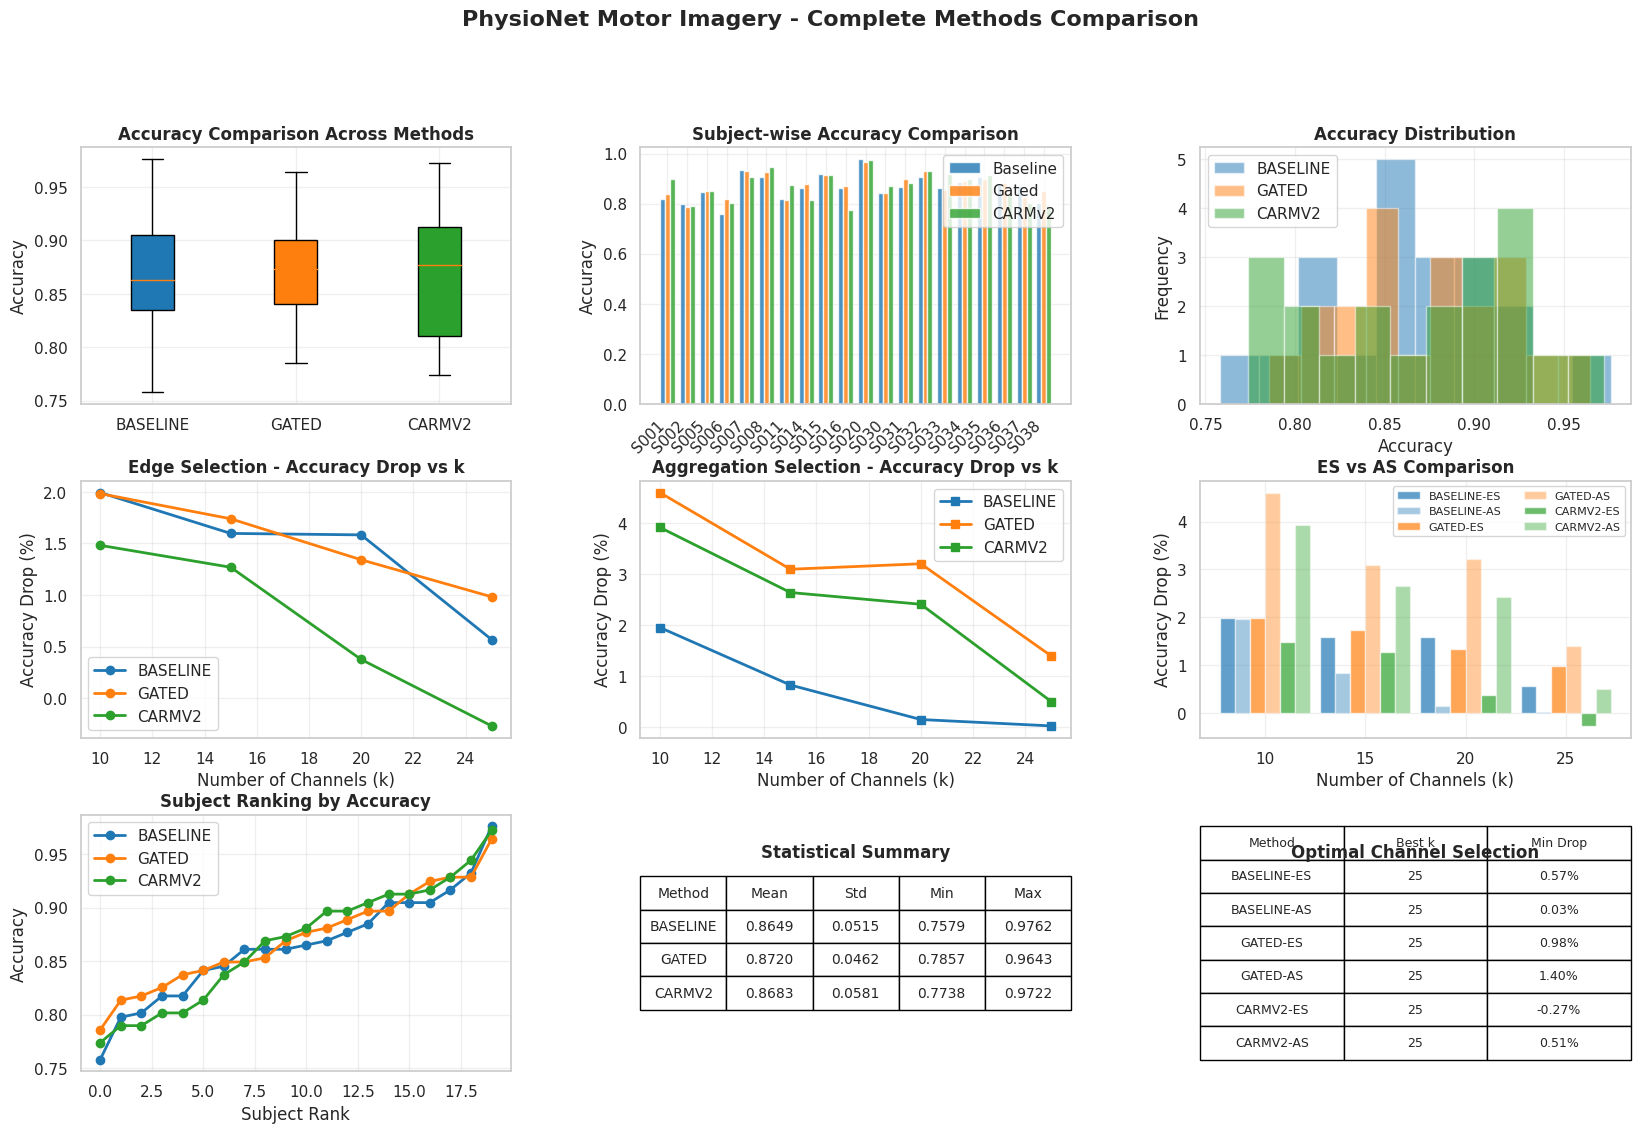


Visualization complete!


In [15]:
import warningswarnings.filterwarnings('ignore')# Set plotting stylesns.set_style('whitegrid')colors = {'baseline': '#3498db', 'static': '#e74c3c', 'adaptive': '#2ecc71', 'halting': '#f39c12'}fig = plt.figure(figsize=(20, 12))gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)# 1. Accuracy comparison across methodsax1 = fig.add_subplot(gs[0, 0])data_for_box = []labels_for_box = []for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if model_type in results_dfs:        data_for_box.append(results_dfs[model_type]['accuracy'].values)        labels_for_box.append(model_type.upper())bp = ax1.boxplot(data_for_box, labels=labels_for_box, patch_artist=True)for patch, model in zip(bp['boxes'], ['baseline', 'gated', 'carmv2']):    patch.set_facecolor(colors[model])ax1.set_ylabel('Accuracy')ax1.set_title('Accuracy Comparison Across Methods', fontweight='bold')ax1.grid(True, alpha=0.3)# 2. Subject-wise comparisonax2 = fig.add_subplot(gs[0, 1])if 'baseline' in results_dfs and 'gated' in results_dfs and 'carmv2' in results_dfs:    subjects_plot = results_dfs['baseline']['subject'].values    x = np.arange(len(subjects_plot))    width = 0.25        ax2.bar(x - width, results_dfs['baseline']['accuracy'].values, width,            label='Baseline', color=colors['baseline'], alpha=0.8)    ax2.bar(x, results_dfs['gated']['accuracy'].values, width,            label='Gated', color=colors['gated'], alpha=0.8)    ax2.bar(x + width, results_dfs['carmv2']['accuracy'].values, width,            label='CARMv2', color=colors['carmv2'], alpha=0.8)        ax2.set_xticks(x)    ax2.set_xticklabels(subjects_plot, rotation=45, ha='right')    ax2.set_ylabel('Accuracy')    ax2.set_title('Subject-wise Accuracy Comparison', fontweight='bold')    ax2.legend()    ax2.grid(True, alpha=0.3)# 3. Accuracy distribution histogramsax3 = fig.add_subplot(gs[0, 2])for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if model_type in results_dfs:        ax3.hist(results_dfs[model_type]['accuracy'], bins=10, alpha=0.5,                 label=model_type.upper(), color=colors[model_type])ax3.set_xlabel('Accuracy')ax3.set_ylabel('Frequency')ax3.set_title('Accuracy Distribution', fontweight='bold')ax3.legend()ax3.grid(True, alpha=0.3)# 4. Channel selection - ES methodax4 = fig.add_subplot(gs[1, 0])for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if model_type in retrain_dfs:        es_data = retrain_dfs[model_type][retrain_dfs[model_type]['method'] == 'ES']        es_grouped = es_data.groupby('k')['accuracy_drop_pct'].mean()        ax4.plot(es_grouped.index, es_grouped.values, marker='o',                 label=model_type.upper(), color=colors[model_type], linewidth=2)ax4.set_xlabel('Number of Channels (k)')ax4.set_ylabel('Accuracy Drop (%)')ax4.set_title('Edge Selection - Accuracy Drop vs k', fontweight='bold')ax4.legend()ax4.grid(True, alpha=0.3)# 5. Channel selection - AS methodax5 = fig.add_subplot(gs[1, 1])for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if model_type in retrain_dfs:        as_data = retrain_dfs[model_type][retrain_dfs[model_type]['method'] == 'AS']        as_grouped = as_data.groupby('k')['accuracy_drop_pct'].mean()        ax5.plot(as_grouped.index, as_grouped.values, marker='s',                 label=model_type.upper(), color=colors[model_type], linewidth=2)ax5.set_xlabel('Number of Channels (k)')ax5.set_ylabel('Accuracy Drop (%)')ax5.set_title('Aggregation Selection - Accuracy Drop vs k', fontweight='bold')ax5.legend()ax5.grid(True, alpha=0.3)# 6. Comparison of channel selection methodsax6 = fig.add_subplot(gs[1, 2])k_values = CONFIG['channel_selection']['k_values']x_pos = np.arange(len(k_values))width = 0.15for i, model_type in enumerate(['baseline', 'gated', 'carmv2']):    if model_type in retrain_dfs:        es_drops = []        as_drops = []        for k in k_values:            es_k = retrain_dfs[model_type][                (retrain_dfs[model_type]['method'] == 'ES') &                 (retrain_dfs[model_type]['k'] == k)            ]['accuracy_drop_pct'].mean()            as_k = retrain_dfs[model_type][                (retrain_dfs[model_type]['method'] == 'AS') &                 (retrain_dfs[model_type]['k'] == k)            ]['accuracy_drop_pct'].mean()            es_drops.append(es_k)            as_drops.append(as_k)                ax6.bar(x_pos + i*width*2, es_drops, width,                label=f'{model_type.upper()}-ES', color=colors[model_type], alpha=0.7)        ax6.bar(x_pos + width + i*width*2, as_drops, width,                label=f'{model_type.upper()}-AS', color=colors[model_type], alpha=0.4)ax6.set_xticks(x_pos + width * 2.5)ax6.set_xticklabels(k_values)ax6.set_xlabel('Number of Channels (k)')ax6.set_ylabel('Accuracy Drop (%)')ax6.set_title('ES vs AS Comparison', fontweight='bold')ax6.legend(ncol=2, fontsize=8)ax6.grid(True, alpha=0.3)# 7. Convergence speed comparisonax7 = fig.add_subplot(gs[2, 0])for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if model_type in results_dfs:        sorted_accs = results_dfs[model_type]['accuracy'].sort_values()        ax7.plot(range(len(sorted_accs)), sorted_accs.values,                 marker='o', label=model_type.upper(), color=colors[model_type], linewidth=2)ax7.set_xlabel('Subject Rank')ax7.set_ylabel('Accuracy')ax7.set_title('Subject Ranking by Accuracy', fontweight='bold')ax7.legend()ax7.grid(True, alpha=0.3)# 8. Statistical significance tableax8 = fig.add_subplot(gs[2, 1])ax8.axis('tight')ax8.axis('off')stats_data = []for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if model_type in results_dfs:        df = results_dfs[model_type]        stats_data.append([            model_type.upper(),            f"{df['accuracy'].mean():.4f}",            f"{df['accuracy'].std():.4f}",            f"{df['accuracy'].min():.4f}",            f"{df['accuracy'].max():.4f}"        ])table = ax8.table(cellText=stats_data,                  colLabels=['Method', 'Mean', 'Std', 'Min', 'Max'],                 cellLoc='center', loc='center')table.auto_set_font_size(False)table.set_fontsize(10)table.scale(1, 2)ax8.set_title('Statistical Summary', fontweight='bold', y=0.8)# 9. Best k for each methodax9 = fig.add_subplot(gs[2, 2])best_k_data = []for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if model_type in retrain_dfs:        for method in ['ES', 'AS']:            method_data = retrain_dfs[model_type][                retrain_dfs[model_type]['method'] == method            ]            grouped = method_data.groupby('k')['accuracy_drop_pct'].mean()            best_k = grouped.idxmin()            best_drop = grouped.min()            best_k_data.append([f'{model_type.upper()}-{method}', best_k, f'{best_drop:.2f}%'])ax9.axis('tight')ax9.axis('off')table2 = ax9.table(cellText=best_k_data,                  colLabels=['Method', 'Best k', 'Min Drop'],                  cellLoc='center', loc='center')table2.auto_set_font_size(False)table2.set_fontsize(9)table2.scale(1, 2)ax9.set_title('Optimal Channel Selection', fontweight='bold', y=0.8)plt.suptitle('PhysioNet Motor Imagery - Complete Methods Comparison',             fontsize=16, fontweight='bold', y=0.995)plt.savefig(CONFIG['output']['results_dir'] / 'complete_comparison.png',            dpi=300, bbox_inches='tight')plt.show()print("\nVisualization complete!")

## 14. Detailed Comparison Tables

In [16]:
# Create comparison table
if all(m in results_dfs for m in ['baseline', 'gated', 'carmv2']):
    comparison_df = results_dfs['baseline'][['subject', 'num_trials', 'num_channels']].copy()
    comparison_df['baseline_acc'] = results_dfs['baseline']['accuracy']
    comparison_df['gated_acc'] = results_dfs['gated']['accuracy']
    comparison_df['carmv2_acc'] = results_dfs['carmv2']['accuracy']
    
    comparison_df['gated_vs_baseline'] = comparison_df['gated_acc'] - comparison_df['baseline_acc']
    comparison_df['carmv2_vs_baseline'] = comparison_df['carmv2_acc'] - comparison_df['baseline_acc']
    comparison_df['carmv2_vs_gated'] = comparison_df['carmv2_acc'] - comparison_df['gated_acc']
    
    print("\n" + "="*80)
    print("DETAILED COMPARISON TABLE")
    print("="*80 + "\n")
    print(comparison_df.to_string())
    
    comparison_df.to_csv(CONFIG['output']['results_dir'] / 'detailed_comparison.csv', index=False)
    
    # Summary statistics
    print("\n" + "="*80)
    print("IMPROVEMENT STATISTICS")
    print("="*80)
    print(f"\nGated vs Baseline:")
    print(f"  Mean improvement: {comparison_df['gated_vs_baseline'].mean():.4f}")
    print(f"  Std: {comparison_df['gated_vs_baseline'].std():.4f}")
    print(f"  Better in {(comparison_df['gated_vs_baseline'] > 0).sum()}/{len(comparison_df)} subjects")
    
    print(f"\nCARMv2 vs Baseline:")
    print(f"  Mean improvement: {comparison_df['carmv2_vs_baseline'].mean():.4f}")
    print(f"  Std: {comparison_df['carmv2_vs_baseline'].std():.4f}")
    print(f"  Better in {(comparison_df['carmv2_vs_baseline'] > 0).sum()}/{len(comparison_df)} subjects")
    
    print(f"\nCARMv2 vs Gated:")
    print(f"  Mean improvement: {comparison_df['carmv2_vs_gated'].mean():.4f}")
    print(f"  Std: {comparison_df['carmv2_vs_gated'].std():.4f}")
    print(f"  Better in {(comparison_df['carmv2_vs_gated'] > 0).sum()}/{len(comparison_df)} subjects")


DETAILED COMPARISON TABLE

   subject  num_trials  num_channels  baseline_acc  gated_acc  carmv2_acc  gated_vs_baseline  carmv2_vs_baseline  carmv2_vs_gated
0     S001         252            64      0.817460   0.837302    0.896825           0.019841            0.079365         0.059524
1     S002         252            64      0.797619   0.785714    0.789683          -0.011905           -0.007937         0.003968
2     S005         252            64      0.845238   0.849206    0.849206           0.003968            0.003968         0.000000
3     S006         252            64      0.757937   0.817460    0.801587           0.059524            0.043651        -0.015873
4     S007         252            64      0.932540   0.928571    0.904762          -0.003968           -0.027778        -0.023810
5     S008         252            64      0.904762   0.924603    0.944444           0.019841            0.039683         0.019841
6     S011         252            64      0.817460   0.813492 

## 15. Final Summary and Conclusions

In [17]:
print("\n" + "="*80)print("FINAL SUMMARY")print("="*80 + "\n")print("Dataset Information:")print(f"  - Total subjects processed: {len(subjects)}")print(f"  - Excluded subjects: {len(EXCLUDED_SUBJECTS)}")print(f"  - Task runs used: {len(ALL_TASK_RUNS)}")print(f"  - Selected classes: {CONFIG['data']['selected_classes']}")print("\nTraining Configuration:")print(f"  - Folds: {CONFIG['model']['n_folds']}")print(f"  - Epochs: {CONFIG['model']['epochs']}")print(f"  - Batch size: {CONFIG['model']['batch_size']}")print(f"  - Learning rate: {CONFIG['model']['learning_rate']}")print("\nMethod Performance:")for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if model_type in results_dfs:        df = results_dfs[model_type]        print(f"  {model_type.upper()}:")        print(f"    Mean accuracy: {df['accuracy'].mean():.4f} Â± {df['accuracy'].std():.4f}")        print(f"    Range: [{df['accuracy'].min():.4f}, {df['accuracy'].max():.4f}]")print("\nChannel Selection Performance:")for model_type in ['baseline', 'static', 'adaptive', 'halting']:    if model_type in retrain_dfs:        print(f"  {model_type.upper()}:")        for method in ['ES', 'AS']:            method_data = retrain_dfs[model_type][retrain_dfs[model_type]['method'] == method]            avg_drop = method_data['accuracy_drop_pct'].mean()            print(f"    {method}: {avg_drop:.2f}% average drop")print("\nKey Findings:")if all(m in results_dfs for m in ['baseline', 'gated', 'carmv2']):    baseline_mean = results_dfs['baseline']['accuracy'].mean()    gated_mean = results_dfs['gated']['accuracy'].mean()    carmv2_mean = results_dfs['carmv2']['accuracy'].mean()        best_method = max([('Baseline', baseline_mean), ('Gated', gated_mean), ('CARMv2', carmv2_mean)], key=lambda x: x[1])    print(f"  1. Best performing method: {best_method[0]} ({best_method[1]:.4f})")    print(f"  2. Gated improvement over baseline: {(gated_mean - baseline_mean):.4f}")    print(f"  3. CARMv2 improvement over baseline: {(carmv2_mean - baseline_mean):.4f}")print("\n" + "="*80)print("All results saved to:", CONFIG['output']['results_dir'])print("="*80)


FINAL SUMMARY

Dataset Information:
  - Total subjects processed: 20
  - Excluded subjects: 27
  - Task runs used: 12
  - Selected classes: [1, 2]

Training Configuration:
  - Folds: 3
  - Epochs: 30
  - Batch size: 32
  - Learning rate: 0.001

Method Performance:
  BASELINE:
    Mean accuracy: 0.8649 Â± 0.0515
    Range: [0.7579, 0.9762]
  GATED:
    Mean accuracy: 0.8720 Â± 0.0462
    Range: [0.7857, 0.9643]
  CARMV2:
    Mean accuracy: 0.8683 Â± 0.0581
    Range: [0.7738, 0.9722]

Channel Selection Performance:
  BASELINE:
    ES: 1.44% average drop
    AS: 0.74% average drop
  GATED:
    ES: 1.51% average drop
    AS: 3.08% average drop
  CARMV2:
    ES: 0.71% average drop
    AS: 2.37% average drop

Key Findings:
  1. Best performing method: Gated (0.8720)
  2. Gated improvement over baseline: 0.0071
  3. CARMv2 improvement over baseline: 0.0034

All results saved to: results
